In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib
sns.set(style="whitegrid")

In [4]:
df = pd.read_csv("../02_data_cleaning/clean_data/cars_merged.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (2496, 17)


,ref_no,title,make,model,year,mileage,engine_cc,transmission,fuel,seats,location,price_usd,total_price_usd,price_ugx,total_price_ugx,url,source
0,BY759022,2006 HONDA ACTY TRUCK,Honda,Acty,2006,111250.0,6500.0,MT,Petrol,2,Location,2370,397300.0,8532000,1.430280e+09,/honda/acty-truck/by759022/id/11910020/,BeForward
1,BY759024,2013 MITSUBISHI CANTER,Mitsubishi,Canter,2013,312401.0,29900.0,Semi AT,Diesel,3,Location,3920,774700.0,14112000,2.788920e+09,/mitsubishi/canter/by759024/id/11910065/,BeForward
2,CA462307,2014 TOYOTA HIACE VAN\n ...,Toyota,Hiace,2014,161352.0,29800.0,AT,Diesel,3,Location,5960,849200.0,21456000,3.057120e+09,/toyota/hiace-van/ca462307/id/12565207/,BeForward
3,CA740447,2011 TOYOTA WISH\n ...,Toyota,Wish,2011,154001.0,17900.0,AT,Petrol,7,Location,2430,454400.0,8748000,1.635840e+09,/toyota/wish/ca740447/id/12831915/,BeForward
4,CB026605,2017 HONDA FIT HYBRID\n ...,Honda,Fit,2017,111072.0,14900.0,AT,Hybrid(Petrol),5,Location,4790,663300.0,17244000,2.387880e+09,/honda/fit-hybrid/cb026605/id/13106276/,BeForward


In [5]:
# Choose features likely to influence price
features = [
    "make",
    "model",
    "year",
    "mileage",
    "engine_cc",
    "transmission",
    "fuel",
    "seats",
    "source"
]

target = "price_ugx"

# Filter only available columns
df_ml = df[features + [target]].copy()

print(df_ml.isnull().sum())

make             0
model            0
year             0
mileage          0
engine_cc       25
transmission     0
fuel             0
seats            0
source           0
price_ugx        0
dtype: int64


In [6]:
def force_numeric(val):
    """Convert values like 'ASK', '-', '--', '', NaN into proper numeric NaN."""
    if pd.isna(val):
        return np.nan
    val = str(val).strip().lower()

    if val in ["ask", "-", "--", "unknown", "", "nan"]:
        return np.nan

    # remove non-digits
    digits = re.sub(r"\D", "", val)
    return float(digits) if digits else np.nan

df_ml["mileage"] = df_ml["mileage"].apply(force_numeric)
df_ml["engine_cc"] = df_ml["engine_cc"].apply(force_numeric)
df_ml["year"] = df_ml["year"].apply(force_numeric)
df_ml["seats"] = df_ml["seats"].apply(force_numeric)


In [7]:
df_ml["year"] = df_ml["year"].fillna(df_ml["year"].median())
df_ml["mileage"] = df_ml["mileage"].fillna(df_ml["mileage"].median())
df_ml["engine_cc"] = df_ml["engine_cc"].fillna(df_ml["engine_cc"].median())

df_ml["fuel"] = df_ml["fuel"].fillna("Unknown")
df_ml["transmission"] = df_ml["transmission"].fillna("Unknown")
df_ml["make"] = df_ml["make"].fillna("Unknown")
df_ml["model"] = df_ml["model"].fillna("Unknown")
df_ml["seats"] = df_ml["seats"].fillna(4)

df_ml["source"] = df_ml["source"].fillna("Unknown")

In [8]:
X = df_ml[features]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (1996, 9)
Test size: (500, 9)


In [9]:
numeric_features = ["year", "mileage", "engine_cc", "seats"]
categorical_features = ["make", "model", "transmission", "fuel", "source"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [10]:
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

In [11]:
results = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")

    pipeline = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

    print(f" MAE: {mae:,.2f}")
    print(f" RMSE: {rmse:,.2f}")
    print(f" R²: {r2:.4f}")

# Display comparison
pd.DataFrame(results).T



Training model: LinearRegression
 MAE: 15,266,875.90
 RMSE: 28,269,290.98
 R²: 0.6376

Training model: DecisionTree
 MAE: 12,282,117.60
 RMSE: 27,673,183.18
 R²: 0.6527

Training model: RandomForest
 MAE: 9,557,499.62
 RMSE: 21,925,849.94
 R²: 0.7820

Training model: GradientBoosting
 MAE: 10,960,668.51
 RMSE: 21,348,166.30
 R²: 0.7933


,MAE,RMSE,R2
LinearRegression,1.526688e+07,2.826929e+07,0.637572
DecisionTree,1.228212e+07,2.767318e+07,0.652696
RandomForest,9.557500e+06,2.192585e+07,0.781976
GradientBoosting,1.096067e+07,2.134817e+07,0.793313


In [12]:
best_model_name = max(results, key=lambda m: results[m]["R2"])
best_model = models[best_model_name]

print("\nBest Model:", best_model_name)

final_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", best_model)
])

final_pipeline.fit(X, y)

joblib.dump(final_pipeline, "models/price_prediction_model.pkl")
print("\nModel saved as price_prediction_model.pkl")



Best Model: GradientBoosting

Model saved as price_prediction_model.pkl


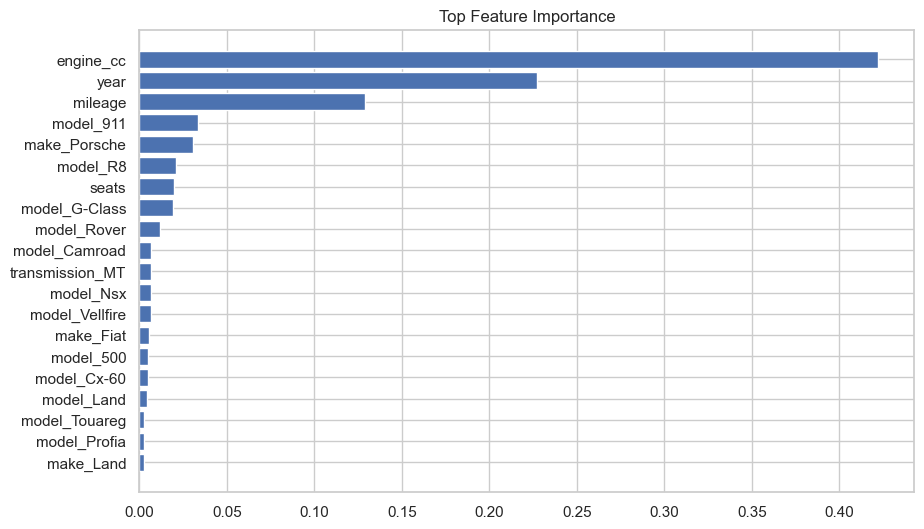

In [13]:
if best_model_name in ["RandomForest", "DecisionTree", "GradientBoosting"]:
    model = final_pipeline.named_steps["model"]

    # Encoding expands categorical features → we retrieve names:
    encoded_features = (
        final_pipeline.named_steps["preprocess"]
        .named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
    )

    feature_names = numeric_features + list(encoded_features)

    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:]  # top 20

    plt.figure(figsize=(10,6))
    plt.barh(range(len(indices)), importances[indices], align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title("Top Feature Importance")
    plt.show()
